<a href="https://colab.research.google.com/github/harrisuddin/F20DL/blob/main/Imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chapter 10: “Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow by Aurélien Géron (O’Reilly). Copyright 2019 Aurélien Géron, 978-1-492-03264-9.”
Code from:
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb


# Building an Image Classifier
We will use Fashion MNIST data set. It has the exact same format as MNIST (70,000 grayscale images of 28×28 pixels each, with 10 classes), but the images represent fashion items rather than handwritten digits, so each class is more diverse and the problem turns out to be significantly more challenging than MNIST. For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST.

In [26]:
import sklearn
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [27]:
tf.__version__

'2.9.2'

In [28]:
keras.__version__

'2.9.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in keras.datasets. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [29]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

When loading MNIST or Fashion MNIST using Keras rather than Scikit-Learn, one important difference is that every image is represented as a 28×28 array rather than a 1D array of size 784. Moreover, the pixel intensities are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0). Below find  the shape and data type.

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [30]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [31]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [32]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's imshow() function, with a 'binary' color map:

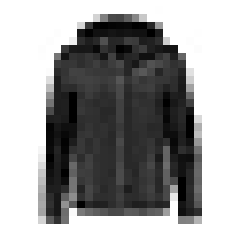

In [33]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [34]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [35]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [36]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [37]:
X_valid.shape

(5000, 28, 28)

In [38]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

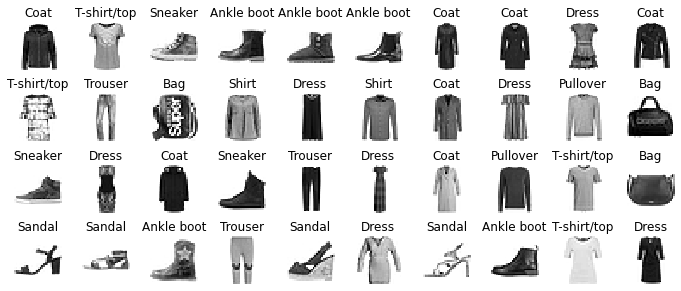

In [39]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let’s build the neural network! Here is a classification MLP with two hidden layers:

In [40]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # first layer convert each input image into a 1D array
model.add(keras.layers.Dense(300, activation="relu")) #hidden layer with 300 neurons useing the ReLU activation function.
model.add(keras.layers.Dense(100, activation="relu")) #hidden layer with 100 neurons using the ReLU

model.add(keras.layers.Dense(10, activation="softmax")) #output layer with 10 neurons (one per class), using the softmax 

In [41]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

You can also pass a list of layers when creating the Sequential model:

In [42]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [43]:
model.layers

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


summary() method displays all the model’s layers including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (None means the batch size can be anything), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. How many non-trainable parameters ?
You can also generate an image of your model using keras.utils.plot_model().

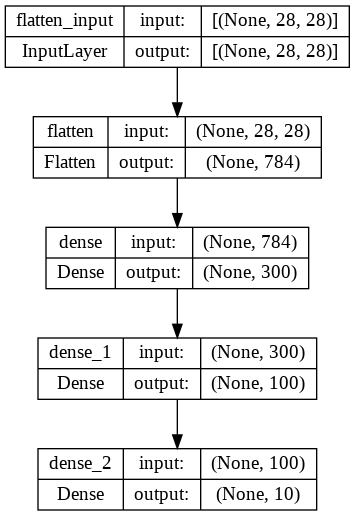

In [45]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

Below you can dispaly differnt layer type and parameters values

In [46]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [47]:
model.get_layer(hidden1.name) is hidden1

True

In [48]:
weights, biases = hidden1.get_weights()

In [49]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [50]:
weights.shape

(784, 300)

In [51]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [52]:
biases.shape

(300,)

After a model is created, you must call its compile() method to specify the loss function and the optimizer (i.e learning rule) to use. 

In [53]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", #"sgd" simply means that we will train the model using simple Stochastic Gradient Descent
              metrics=["accuracy"])

This is equivalent to:

In [54]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(), #"sgd" simply means that we will train the model using simple Stochastic Gradient Descent
              metrics=[keras.metrics.sparse_categorical_accuracy])

We use the "sparse_categorical_crossen tropy" loss because we have sparse labels (i.e., for each instance there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. If we were doing binary classi‐ fication (with one or more binary labels), then we would use the "sigmoid" (i.e., logistic) activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.

Below we train the model; so we call the  fit() method. We pass it the input features (X_train) and the target classes (y_train), as well as the number of epochs to train 

In [55]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7237 - sparse_categorical_accuracy: 0.7643 - val_loss: 0.5213 - val_sparse_categorical_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4842 - sparse_categorical_accuracy: 0.8317 - val_loss: 0.4351 - val_sparse_categorical_accuracy: 0.8538
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4392 - sparse_categorical_accuracy: 0.8454 - val_loss: 0.5360 - val_sparse_categorical_accuracy: 0.7978
Epoch 4/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4124 - sparse_categorical_accuracy: 0.8566 - val_loss: 0.3917 - val_sparse_categorical_accuracy: 0.8648
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3940 - sparse_categorical_accuracy: 0.8619 - val_loss: 0.3749 - val_sparse_categorical_accuracy: 0.8690
Epoch 6/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3751 - spars

Finished training your network in 30 iterations. At each epoch during training, Keras displays the number of instances processed so far (along with a progress bar), the mean training time per sample, the loss and accuracy (or any other extra metrics you asked for), both on the training set and the validation set. You can see that the training loss went down, which is a good sign, and the validation accuracy reached 88.88% after 30 epochs, not too far from the training accuracy, so there does not seem to be much overfitting going on.

In [56]:
history.params # fit method returns History object; which contains the training parameters (history.params)

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [57]:
print(history.epoch) # list of epochs it went through (history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [58]:
history.history.keys() # contains the  metrics measured at the end of each epoch on the training set and on the validation set

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

plot() method, plots learning curves ( accuracy, loss on validation and training against the epochs)
By inspecting your learning curve, you can see how well your classifier is learning abd wether you have overfitting. Comment on the figure below.


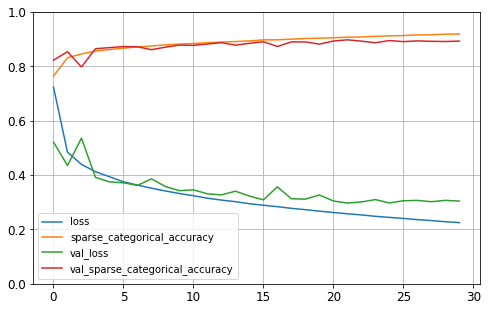

In [59]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [60]:
model.evaluate(X_test, y_test) # now finally time to evaluate your model on the testing set

313/313 [==============================] - 1s 3ms/step - loss: 0.3366 - sparse_categorical_accuracy: 0.8835


[0.33657705783843994, 0.8834999799728394]

Are you happy with the results on your test set? If not, what would be you do?
What can you say about your generalization error?


In [61]:
X_new = X_test[:3] # make predictions on  first 3 instances of the test set 
y_proba = model.predict(X_new)
y_proba.round(2) # For each instance the model estimates one probability per class, from class 0 to class 9

1/1 [==============================] - 0s 93ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [62]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 17ms/step


array([9, 2, 1])

In [63]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [64]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

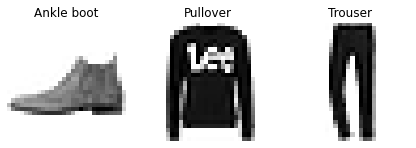

In [65]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()